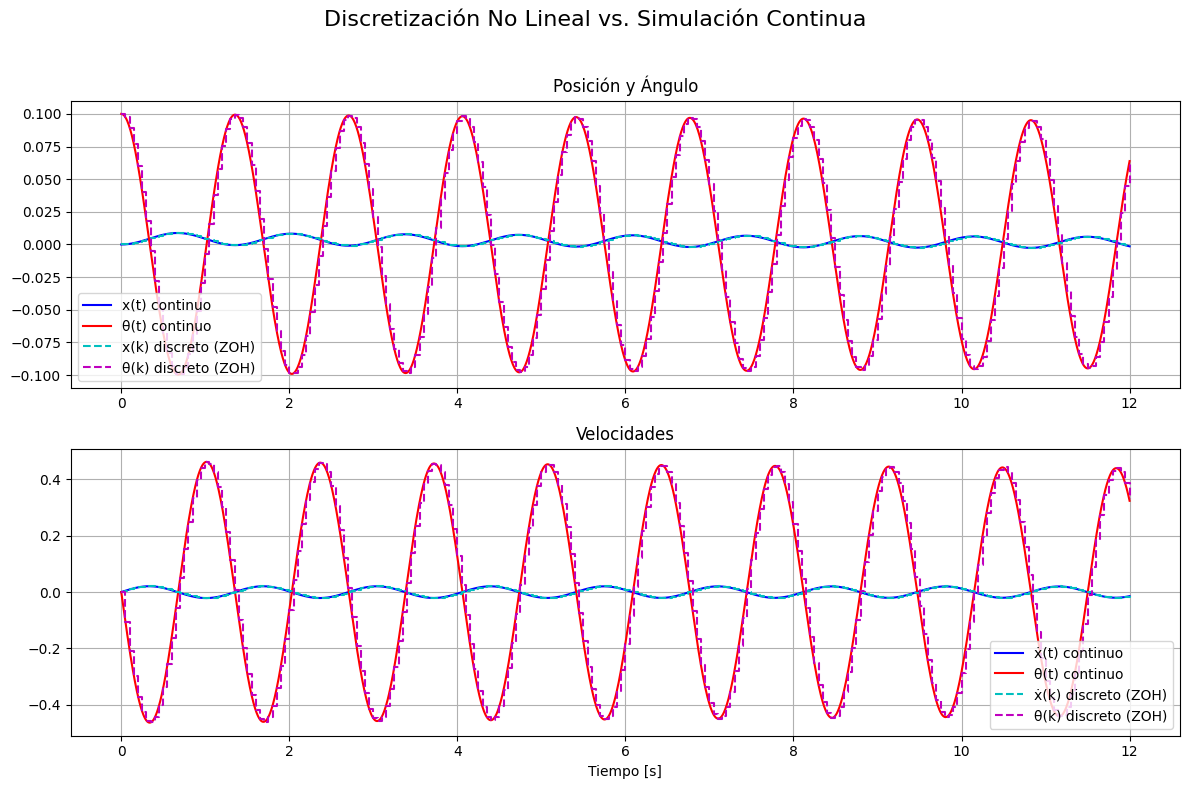

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


M = 1.0   # masa del carro [kg]
m = 0.1   # masa del péndulo [kg]
l = 0.5   # longitud del péndulo [m]
b = 0.1   # fricción
g = 9.81  # gravedad

# Ecuaciones de estado continuas
def continuous_dynamics(t, state, F):
    x, x_dot, theta, theta_dot = state

    # Construcción de ecuaciones
    denom = M + m*np.sin(theta)**2

    x_ddot = (F - b*x_dot + m*np.sin(theta)*(l*theta_dot**2 + g*np.cos(theta))) / denom
    theta_ddot = (-F*np.cos(theta) + b*x_dot*np.cos(theta) - (M+m)*g*np.sin(theta)
                  - m*l*theta_dot**2*np.sin(theta)*np.cos(theta)) / (l*denom)

    return [x_dot, x_ddot, theta_dot, theta_ddot]


def discretize_nonlinear_zoh(current_state, control_input, h):
    """
    Calcula el siguiente estado x(k+1) a partir de x(k) y u(k)
    integrando el modelo no lineal durante un período h con control constante.
    
    Args:
        current_state (array): El estado actual x(k) = [x, x_dot, theta, theta_dot].
        control_input (float): La fuerza constante u(k) = F a aplicar.
        h (float): El período de muestreo.
        
    Returns:
        array: El estado en el siguiente instante de muestreo, x(k+1).
    """
    # Definimos el intervalo de tiempo para la integración de este paso
    t_span_step = (0, h)
    
    # Usamos solve_ivp para integrar las dinámicas durante un período h
    # La fuerza 'F' se pasa como un argumento adicional a 'continuous_dynamics'
    sol_step = solve_ivp(
        fun=continuous_dynamics,
        t_span=t_span_step,
        y0=current_state,
        method='RK45',
        args=(control_input,) # ¡Importante! Pasa la fuerza como argumento
    )
    
    # El estado final de esta integración es el estado en el siguiente instante de muestreo
    next_state = sol_step.y[:, -1]
    
    return next_state

# ==============================================================================
#      SIMULACIÓN DEL MODELO DISCRETO
# ==============================================================================

# Parámetros de la simulación discreta
h = 0.05  # Período de muestreo (20 Hz)
T_final = 12
N_steps = int(T_final / h)

# Condiciones iniciales
# x, dx, theta=0,1, dtheta
state0_discrete = np.array([0.0, 0.0, 0.1, 0.0])

# Arrays para guardar el historial
states_history = np.zeros((4, N_steps + 1))
time_history = np.zeros(N_steps + 1)
control_history = np.zeros(N_steps)

states_history[:, 0] = state0_discrete
time_history[0] = 0

# Bucle de simulación discreto
current_state = state0_discrete
for k in range(N_steps):
    
    control_input_k = 0.0
    
    # Calcular el siguiente estado usando nuestra función de discretización
    next_state = discretize_nonlinear_zoh(current_state, control_input_k, h)
    
    # Guardar los resultados
    states_history[:, k+1] = next_state
    time_history[k+1] = (k+1) * h
    control_history[k] = control_input_k
    
    # Actualizar el estado para la siguiente iteración
    current_state = next_state

# Resolver el sistema continuo para tener una referencia de alta fidelidad
t_eval_cont = np.linspace(0, T_final, 2000)
sol_cont = solve_ivp(lambda t, y: continuous_dynamics(t, y, 0.0), (0, T_final), state0_discrete, t_eval=t_eval_cont)

# Graficar resultados
plt.figure(figsize=(12, 8))
plt.suptitle('Discretización No Lineal vs. Simulación Continua', fontsize=16)

# Posición y Ángulo
plt.subplot(2, 1, 1)
plt.plot(sol_cont.t, sol_cont.y[0], 'b-', label='x(t) continuo')
plt.plot(sol_cont.t, sol_cont.y[2], 'r-', label='θ(t) continuo')
plt.step(time_history, states_history[0], 'c--', where='post', label='x(k) discreto (ZOH)')
plt.step(time_history, states_history[2], 'm--', where='post', label='θ(k) discreto (ZOH)')
plt.title('Posición y Ángulo')
plt.legend()
plt.grid()

# Velocidades
plt.subplot(2, 1, 2)
plt.plot(sol_cont.t, sol_cont.y[1], 'b-', label='ẋ(t) continuo')
plt.plot(sol_cont.t, sol_cont.y[3], 'r-', label='θ̇(t) continuo')
plt.step(time_history, states_history[1], 'c--', where='post', label='ẋ(k) discreto (ZOH)')
plt.step(time_history, states_history[3], 'm--', where='post', label='θ̇(k) discreto (ZOH)')
plt.title('Velocidades')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show(block=True)


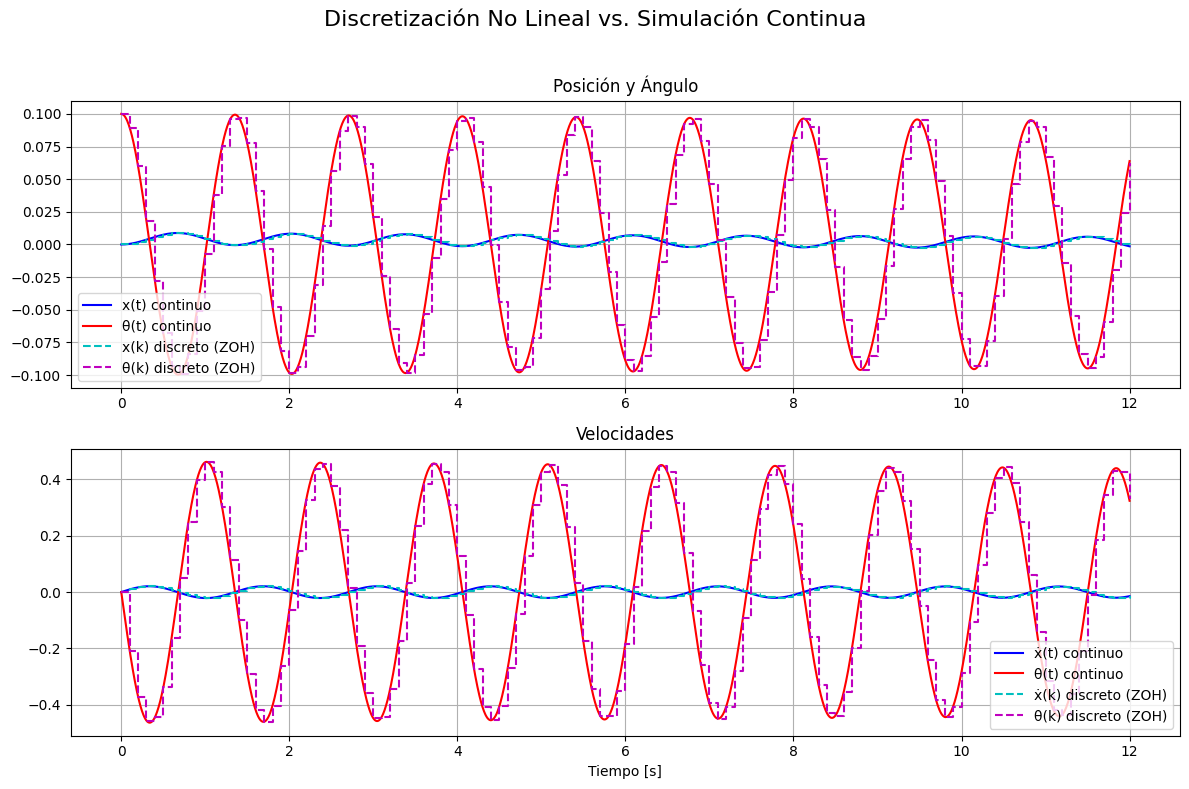

In [2]:
h = 0.1  # Período de muestreo (10 Hz)
T_final = 12
N_steps = int(T_final / h)

# Condiciones iniciales
# x, dx, theta=30°, dtheta
state0_discrete = np.array([0.0, 0.0, 0.1, 0.0])

# Arrays para guardar el historial
states_history = np.zeros((4, N_steps + 1))
time_history = np.zeros(N_steps + 1)
control_history = np.zeros(N_steps)

states_history[:, 0] = state0_discrete
time_history[0] = 0

# Bucle de simulación discreto
current_state = state0_discrete
for k in range(N_steps):
    
    control_input_k = 0.0
    
    # Calcular el siguiente estado usando nuestra función de discretización
    next_state = discretize_nonlinear_zoh(current_state, control_input_k, h)
    
    # Guardar los resultados
    states_history[:, k+1] = next_state
    time_history[k+1] = (k+1) * h
    control_history[k] = control_input_k
    
    # Actualizar el estado para la siguiente iteración
    current_state = next_state

# Resolver el sistema continuo para tener una referencia de alta fidelidad
t_eval_cont = np.linspace(0, T_final, 2000)
sol_cont = solve_ivp(lambda t, y: continuous_dynamics(t, y, 0.0), (0, T_final), state0_discrete, t_eval=t_eval_cont)

# Graficar resultados
plt.figure(figsize=(12, 8))
plt.suptitle('Discretización No Lineal vs. Simulación Continua', fontsize=16)

# Posición y Ángulo
plt.subplot(2, 1, 1)
plt.plot(sol_cont.t, sol_cont.y[0], 'b-', label='x(t) continuo')
plt.plot(sol_cont.t, sol_cont.y[2], 'r-', label='θ(t) continuo')
plt.step(time_history, states_history[0], 'c--', where='post', label='x(k) discreto (ZOH)')
plt.step(time_history, states_history[2], 'm--', where='post', label='θ(k) discreto (ZOH)')
plt.title('Posición y Ángulo')
plt.legend()
plt.grid()

# Velocidades
plt.subplot(2, 1, 2)
plt.plot(sol_cont.t, sol_cont.y[1], 'b-', label='ẋ(t) continuo')
plt.plot(sol_cont.t, sol_cont.y[3], 'r-', label='θ̇(t) continuo')
plt.step(time_history, states_history[1], 'c--', where='post', label='ẋ(k) discreto (ZOH)')
plt.step(time_history, states_history[3], 'm--', where='post', label='θ̇(k) discreto (ZOH)')
plt.title('Velocidades')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show(block=True)

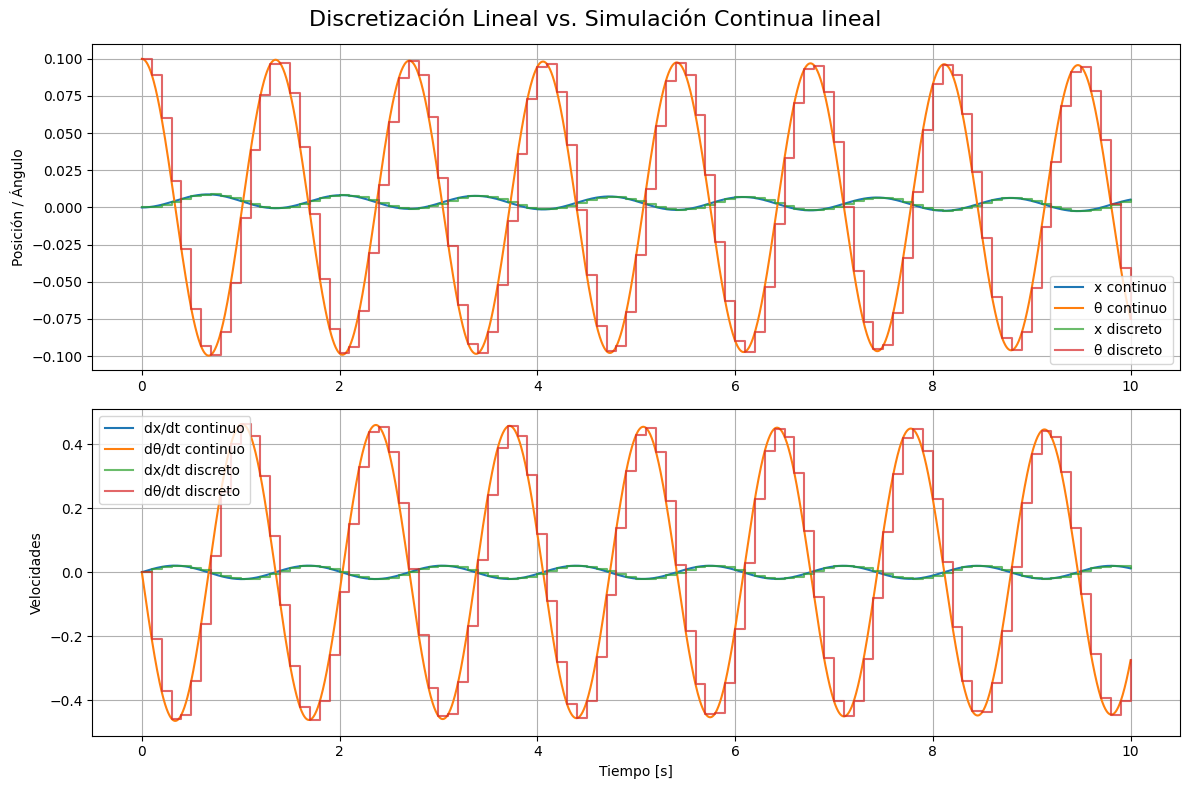

In [23]:
from control import ss, forced_response, c2d
import sympy as sp
# Parámetros físicos
L= 1
I_c = (1/12)*m*L**2   # inercia varilla en su CM
l = L/2               # distancia pivote–CM


x, x_dot, theta, theta_dot, F = sp.symbols('x x_dot theta theta_dot F')

denom = M + m*sp.sin(theta)**2

x_ddot = (F - b*x_dot + m*sp.sin(theta)*(l*theta_dot**2 + g*sp.cos(theta))) / denom
theta_ddot = (-F*sp.cos(theta) + b*x_dot*sp.cos(theta) - (M+m)*g*sp.sin(theta)
            - m*l*theta_dot**2*sp.sin(theta)*sp.cos(theta)) / (l*denom)

states = sp.Matrix([x, x_dot, theta, theta_dot])
f = sp.Matrix([x_dot, x_ddot, theta_dot, theta_ddot])

A = f.jacobian(states)
B = f.jacobian([F])

# Función para linealizar
def linearize(point):
    subs_dict = {x: point[0], x_dot: point[1], theta: point[2], theta_dot: point[3], F: point[4]}
    A_num = np.array(A.evalf(subs=subs_dict), dtype=float)
    B_num = np.array(B.evalf(subs=subs_dict), dtype=float)
    C_num = np.eye(4)   # medimos todos los estados
    D_num = np.zeros((4,1))
    return ss(A_num, B_num, C_num, D_num)


sys_up = linearize([0, 0, 0, 0, 0])

h = 0.1  # tiempo de muestreo
sys_d = c2d(sys_up, h, method='zoh')
sys_d2 = c2d(sys_up, h, method='tustin')
# --- Simulación ---
T = np.linspace(0, 10, 2000)
U = np.zeros_like(T)
X0 = [0.0, 0.0, 0.1, 0.0]

# Respuesta continua
t_cont, y_cont = forced_response(sys_up, T, U, X0)

# Respuesta discreta
t_disc = np.arange(0, T[-1]+h, h)
U_disc = np.zeros_like(t_disc)
t_disc_resp, y_disc = forced_response(sys_d, t_disc, U_disc, X0)
t_disc_resp2, y_disc2 = forced_response(sys_d2, t_disc, U_disc, X0)
# --- Gráficas comparativas ---
plt.figure(figsize=(12, 8))
plt.suptitle('Discretización Lineal vs. Simulación Continua lineal', fontsize=16)


# Posición y ángulo
plt.subplot(2,1,1)
plt.plot(t_cont, y_cont[0], label="x continuo")
plt.plot(t_cont, y_cont[2], label="θ continuo")
plt.step(t_disc_resp, y_disc[0], where='post', label="x discreto", alpha=0.7)
plt.step(t_disc_resp, y_disc[2], where='post', label="θ discreto", alpha=0.7)
plt.ylabel("Posición / Ángulo")
plt.legend()
plt.grid()

# Velocidades
plt.subplot(2,1,2)
plt.plot(t_cont, y_cont[1], label="dx/dt continuo")
plt.plot(t_cont, y_cont[3], label="dθ/dt continuo")
plt.step(t_disc_resp, y_disc[1], where='post', label="dx/dt discreto", alpha=0.7)
plt.step(t_disc_resp, y_disc[3], where='post', label="dθ/dt discreto", alpha=0.7)
plt.ylabel("Velocidades")
plt.xlabel("Tiempo [s]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


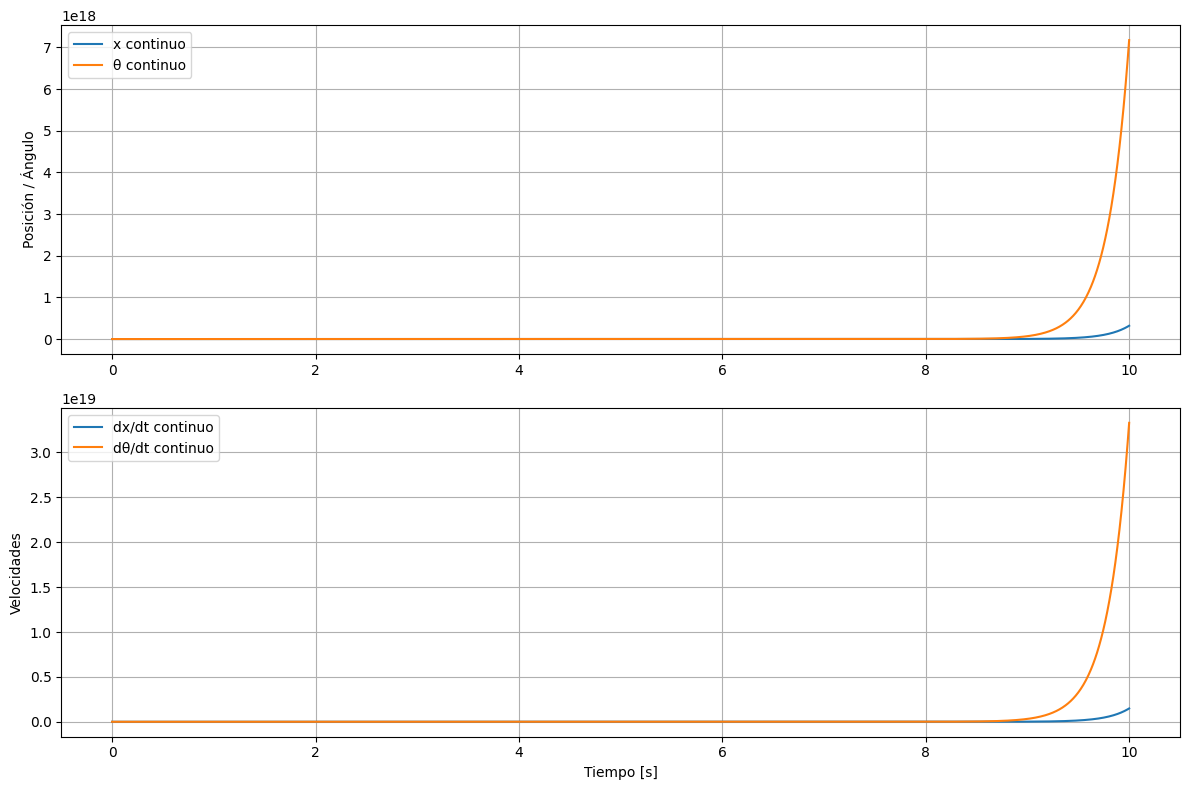

In [4]:
sys_up = linearize([0, 0, np.pi, 0, 0])

# --- Simulación ---
T = np.linspace(0, 10, 2000)
U = np.zeros_like(T)
X0 = [0.0, 0.0, 0.1, 0.0]

# Respuesta continua
t_cont, y_cont = forced_response(sys_up, T, U, X0)

# --- Gráficas comparativas ---
plt.figure(figsize=(12, 8))


# Posición y ángulo
plt.subplot(2,1,1)
plt.plot(t_cont, y_cont[0], label="x continuo")
plt.plot(t_cont, y_cont[2], label="θ continuo")
plt.ylabel("Posición / Ángulo")
plt.legend()
plt.grid()

# Velocidades
plt.subplot(2,1,2)
plt.plot(t_cont, y_cont[1], label="dx/dt continuo")
plt.plot(t_cont, y_cont[3], label="dθ/dt continuo")
plt.ylabel("Velocidades")
plt.xlabel("Tiempo [s]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


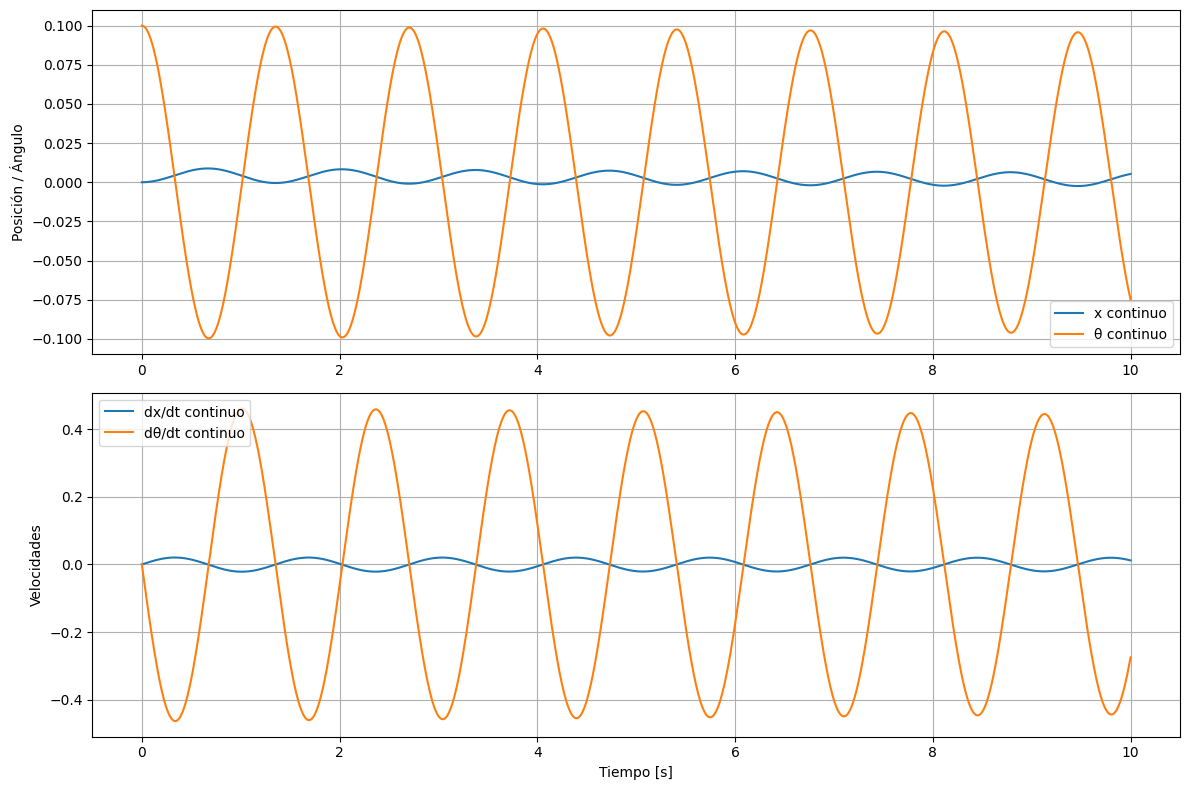

In [5]:
sys_up = linearize([0, 0, 0, 0, 0])

# --- Simulación ---
T = np.linspace(0, 10, 2000)
U = np.zeros_like(T)
X0 = [0.0, 0.0, 0.1, 0.0]

# Respuesta continua
t_cont, y_cont = forced_response(sys_up, T, U, X0)

# --- Gráficas comparativas ---
plt.figure(figsize=(12, 8))


# Posición y ángulo
plt.subplot(2,1,1)
plt.plot(t_cont, y_cont[0], label="x continuo")
plt.plot(t_cont, y_cont[2], label="θ continuo")
plt.ylabel("Posición / Ángulo")
plt.legend()
plt.grid()

# Velocidades
plt.subplot(2,1,2)
plt.plot(t_cont, y_cont[1], label="dx/dt continuo")
plt.plot(t_cont, y_cont[3], label="dθ/dt continuo")
plt.ylabel("Velocidades")
plt.xlabel("Tiempo [s]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

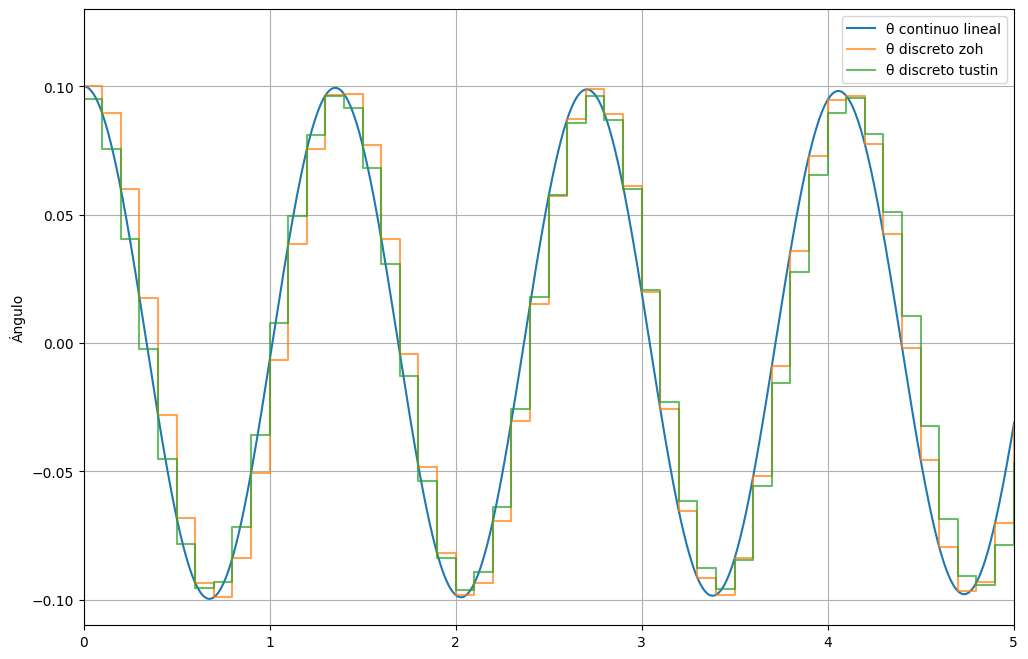

In [6]:
plt.figure(figsize=(12, 8))
plt.ylim(-0.110, 0.130)
plt.xlim(0,5)
plt.plot(t_cont, y_cont[2], label="θ continuo lineal")
plt.step(t_disc_resp, y_disc[2], where='post', label="θ discreto zoh", alpha=0.7)
plt.step(t_disc_resp2, y_disc2[2], where='post', label="θ discreto tustin", alpha=0.7)
plt.ylabel("Ángulo")
plt.legend()
plt.grid()

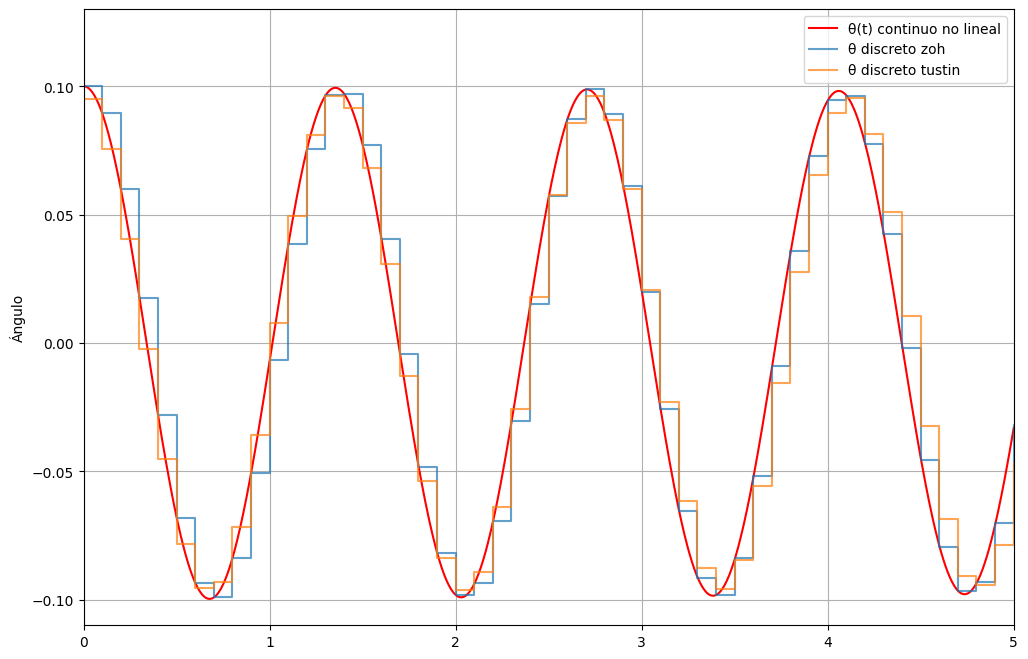

In [7]:
plt.figure(figsize=(12, 8))

plt.plot(sol_cont.t, sol_cont.y[2], 'r-', label='θ(t) continuo no lineal')
plt.ylim(-0.110, 0.130)
plt.xlim(0,5)
plt.step(t_disc_resp, y_disc[2], where='post', label="θ discreto zoh", alpha=0.7)
plt.step(t_disc_resp2, y_disc2[2], where='post', label="θ discreto tustin", alpha=0.7)
plt.ylabel("Ángulo")
plt.legend()
plt.grid()

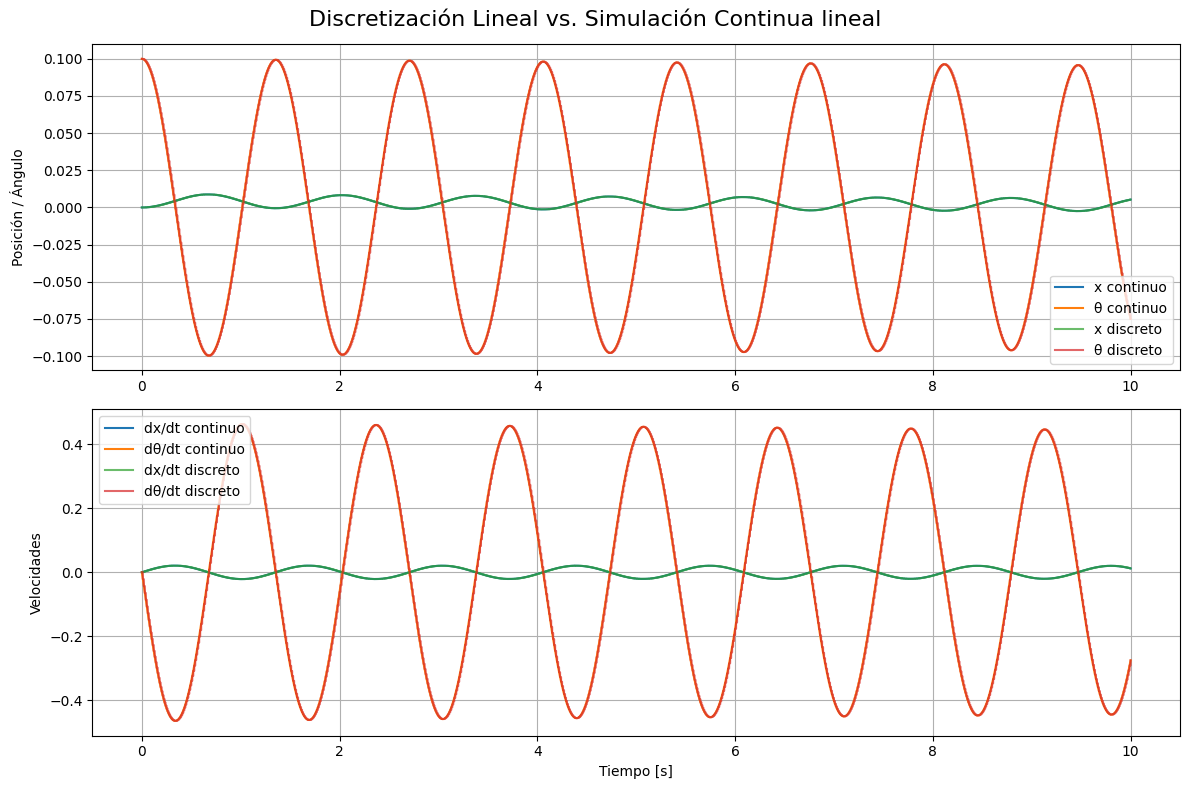

In [8]:
h = 0.01  # tiempo de muestreo
sys_d = c2d(sys_up, h, method='zoh')

# --- Simulación ---
T = np.linspace(0, 10, 2000)
U = np.zeros_like(T)
X0 = [0.0, 0.0, 0.1, 0.0]

# Respuesta continua
t_cont, y_cont = forced_response(sys_up, T, U, X0)

# Respuesta discreta
t_disc = np.arange(0, T[-1]+h, h)
U_disc = np.zeros_like(t_disc)
t_disc_resp, y_disc = forced_response(sys_d, t_disc, U_disc, X0)

# --- Gráficas comparativas ---
plt.figure(figsize=(12, 8))
plt.suptitle('Discretización Lineal vs. Simulación Continua lineal', fontsize=16)

# Posición y ángulo
plt.subplot(2,1,1)
plt.plot(t_cont, y_cont[0], label="x continuo")
plt.plot(t_cont, y_cont[2], label="θ continuo")
plt.step(t_disc_resp, y_disc[0], where='post', label="x discreto", alpha=0.7)
plt.step(t_disc_resp, y_disc[2], where='post', label="θ discreto", alpha=0.7)
plt.ylabel("Posición / Ángulo")
plt.legend()
plt.grid()

# Velocidades
plt.subplot(2,1,2)
plt.plot(t_cont, y_cont[1], label="dx/dt continuo")
plt.plot(t_cont, y_cont[3], label="dθ/dt continuo")
plt.step(t_disc_resp, y_disc[1], where='post', label="dx/dt discreto", alpha=0.7)
plt.step(t_disc_resp, y_disc[3], where='post', label="dθ/dt discreto", alpha=0.7)
plt.ylabel("Velocidades")
plt.xlabel("Tiempo [s]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

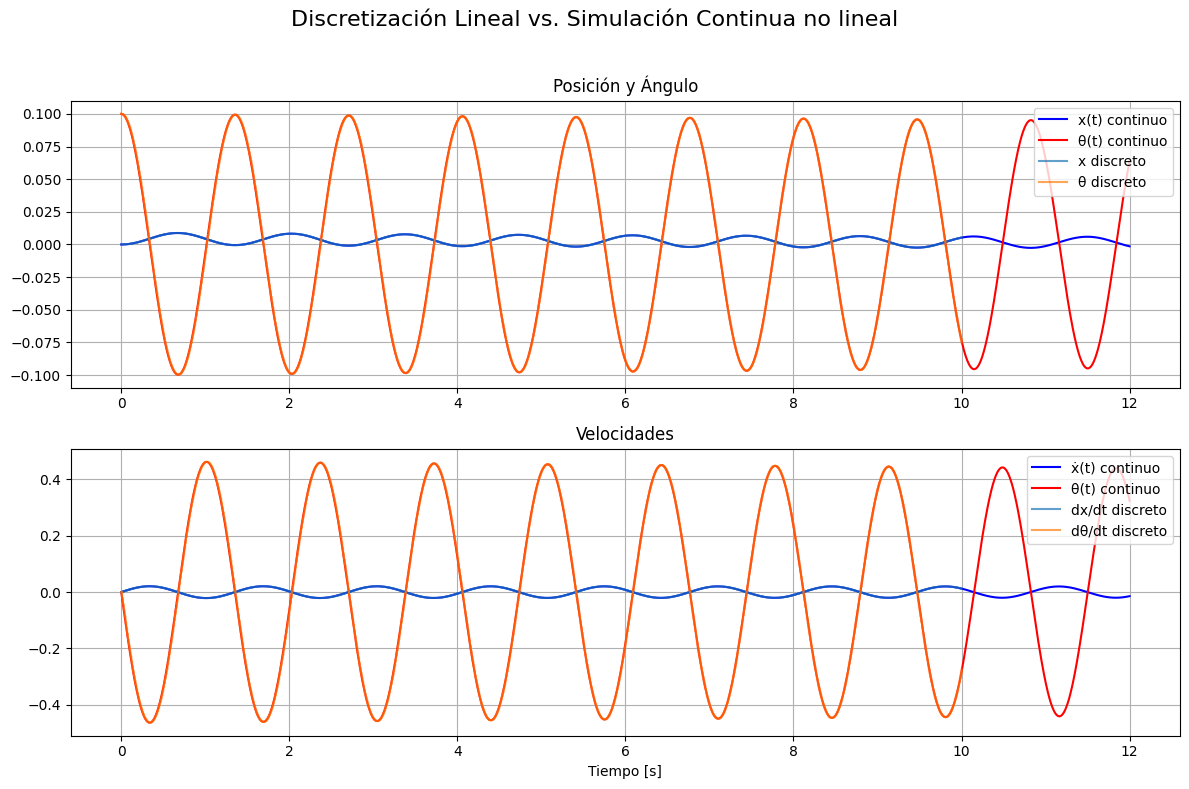

In [9]:


# Graficar resultados
plt.figure(figsize=(12, 8))
plt.suptitle('Discretización Lineal vs. Simulación Continua no lineal', fontsize=16)

# Posición y Ángulo
plt.subplot(2, 1, 1)
plt.plot(sol_cont.t, sol_cont.y[0], 'b-', label='x(t) continuo')
plt.plot(sol_cont.t, sol_cont.y[2], 'r-', label='θ(t) continuo')
plt.step(t_disc_resp, y_disc[0], where='post', label="x discreto", alpha=0.7)
plt.step(t_disc_resp, y_disc[2], where='post', label="θ discreto", alpha=0.7)
plt.title('Posición y Ángulo')
plt.legend()
plt.grid()

# Velocidades
plt.subplot(2, 1, 2)
plt.plot(sol_cont.t, sol_cont.y[1], 'b-', label='ẋ(t) continuo')
plt.plot(sol_cont.t, sol_cont.y[3], 'r-', label='θ̇(t) continuo')
plt.step(t_disc_resp, y_disc[1], where='post', label="dx/dt discreto", alpha=0.7)
plt.step(t_disc_resp, y_disc[3], where='post', label="dθ/dt discreto", alpha=0.7)
plt.title('Velocidades')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show(block=True)

=== θ=0 ===
<TransferFunction>: sys[7]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  5.551e-16 s^3 - 2 s^2 + 5.995e-15 s
  -----------------------------------
  s^4 + 0.1 s^3 + 21.58 s^2 + 1.962 s

=== θ=π ===
<TransferFunction>: sys[9]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  8.882e-16 s^3 + 2 s^2 - 5.995e-15 s
  -----------------------------------
  s^4 + 0.1 s^3 - 21.58 s^2 - 1.962 s


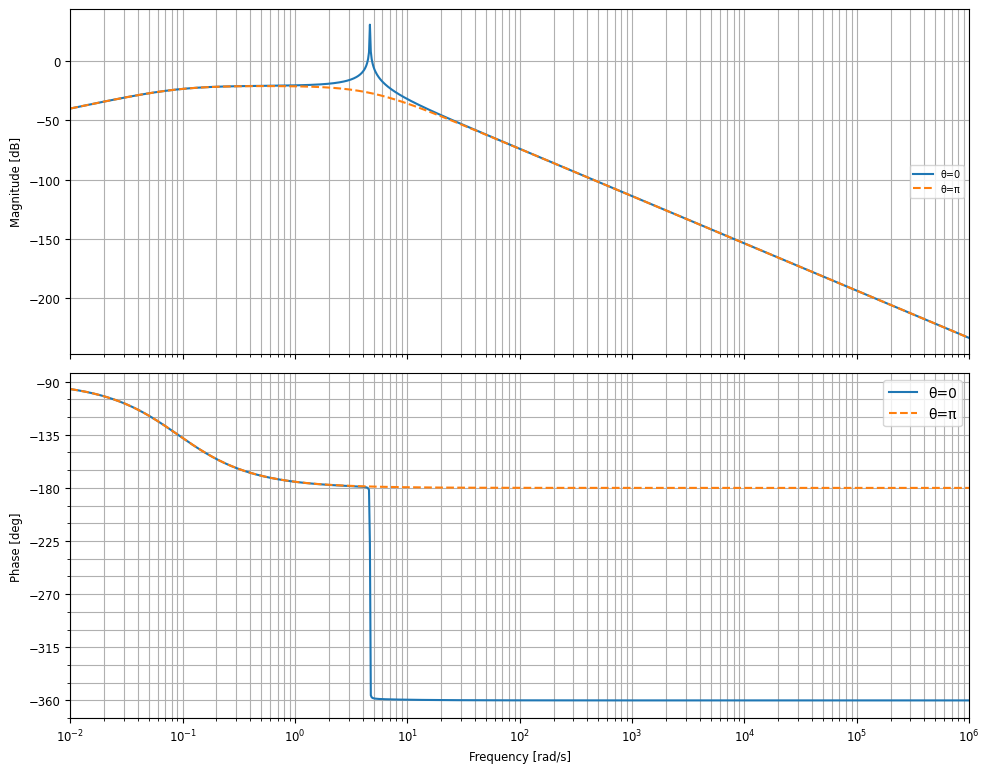

In [10]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import control as ctl

# Variables simbólicas
x1, x2, x3, x4, u = sp.symbols('x1 x2 x3 x4 u')
theta = x3

# Dinámica no lineal (pendulo puntual)
D = sp.Matrix([[M + m, m*l*sp.cos(theta)],
               [m*l*sp.cos(theta), m*l**2]])

rhs = sp.Matrix([u - b*x2 + m*l*sp.sin(theta)*x4**2,
                 - m*g*l*sp.sin(theta)])

xddot, thetaddot = D.LUsolve(rhs)
f = sp.Matrix([x2, xddot, x4, thetaddot])

# Jacobianos
A_sym = f.jacobian([x1, x2, x3, x4])
B_sym = f.jacobian([u])

# Puntos de equilibrio
subs0 = {x1:0, x2:0, x3:0, x4:0, u:0}
subspi = {x1:0, x2:0, x3:sp.pi, x4:0, u:0}

A0 = np.array(A_sym.subs(subs0)).astype(float)
B0 = np.array(B_sym.subs(subs0)).astype(float)
Api = np.array(A_sym.subs(subspi)).astype(float)
Bpi = np.array(B_sym.subs(subspi)).astype(float)

# Salida: ángulo
C = np.array([[0., 0., 1., 0.]])
Dmat = np.zeros((1,1))

# Crear sistemas en control
sys0 = ctl.ss2tf(ctl.ss(A0, B0, C, Dmat))
syspi = ctl.ss2tf(ctl.ss(Api, Bpi, C, Dmat))

print("=== θ=0 ===")
print(sys0)
print("\n=== θ=π ===")
print(syspi)

# Bode
plt.figure(figsize=(10,8))
ctl.bode_plot(sys0, dB=True, label=r'θ=0', omega_limits=[0.01, 1e6])
ctl.bode_plot(syspi, dB=True, linestyle='--', label=r'θ=π', omega_limits=[0.01, 1e6])
plt.suptitle("Diagramas de Bode (F→θ)")
plt.legend()
plt.show()


In [ ]:
180*np.pi/(np.pi*4)

0.1

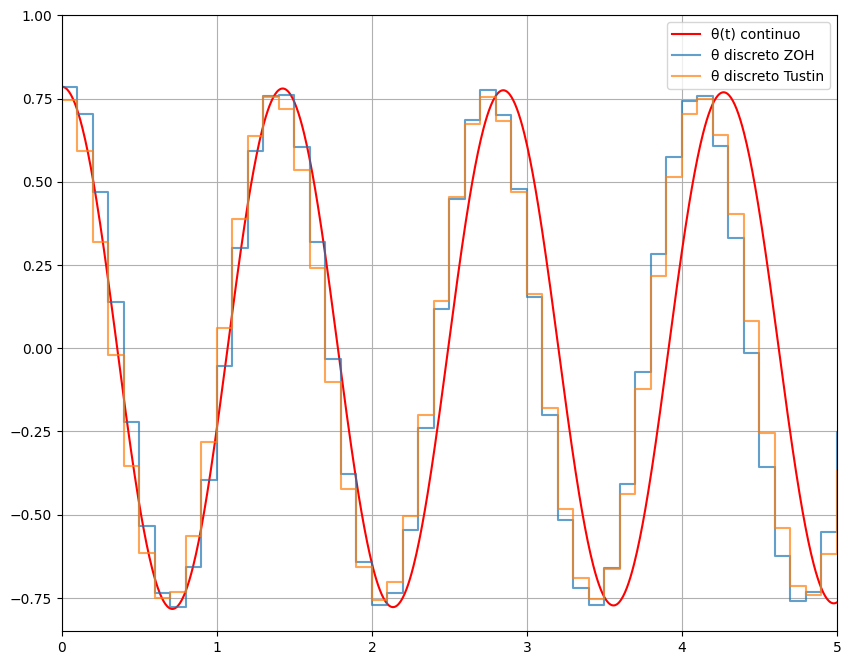

In [14]:
state0_discrete = np.array([0.0, 0.0, np.pi/4, 0.0])

t_eval_cont = np.linspace(0, T_final, 2000)
sol_cont = solve_ivp(lambda t, y: continuous_dynamics(t, y, 0.0), (0, T_final), state0_discrete, t_eval=t_eval_cont)

t_disc = np.arange(0, T[-1]+h, h)
U_disc = np.zeros_like(t_disc)
X0 = [0.0, 0.0, np.pi/4, 0.0]

# Respuesta continua
t_disc_resp, y_disc = forced_response(sys_d, t_disc, U_disc, X0)
t_disc_resp2, y_disc2 = forced_response(sys_d2, t_disc, U_disc, X0)
plt.figure(figsize=(10,8))
plt.xlim(0,5)
plt.ylim(-0.85,1)
plt.plot(sol_cont.t, sol_cont.y[2], 'r-', label='θ(t) continuo')
plt.step(t_disc_resp, y_disc[2], where='post', label="θ discreto ZOH", alpha=0.7)
plt.step(t_disc_resp2, y_disc2[2], where='post', label="θ discreto Tustin", alpha=0.7)
plt.legend()
plt.grid()
plt.show()

C:\Users\leone\AppData\Local\Temp\ipykernel_14416\4191732543.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill")


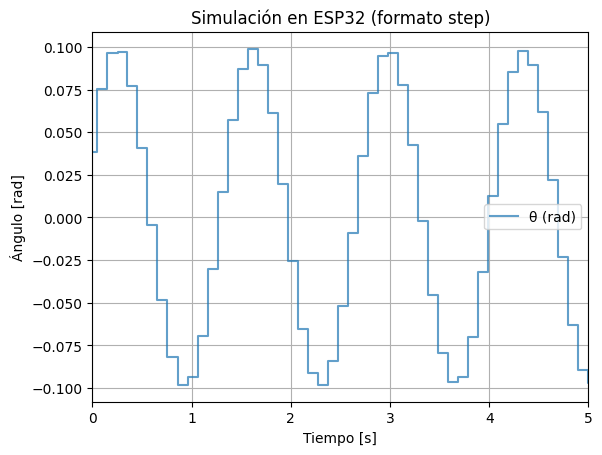

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("teleplot_export.csv")
# El timestamp que guarda Teleplot está en la primera columna
# Lo convertimos en tiempo relativo (t=0 en la primera muestra)
t = df.iloc[:,0] - df.iloc[0,0]

# Reemplazar NaN con último valor válido
df = df.fillna(method="ffill")

# Suponiendo que la señal "theta" está en la columna llamada 'theta'
theta = df["theta"]

# Graficar con estilo escalonado
plt.step(t, theta, where="post", label="θ (rad)",  alpha=0.7)
plt.xlim(0,5)
plt.xlabel("Tiempo [s]")
plt.ylabel("Ángulo [rad]")
plt.title("Simulación en ESP32 (formato step)")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
sys_d.B

array([[ 0.00497529],
       [ 0.09917979],
       [-0.00978858],
       [-0.19190598]])

In [38]:
8.94048773e-01

0.894048773